### 転移学習を行なっている
### ネット上のパラメーターを読み込み

In [ ]:
!wget https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

###### 7/1　選定したringで学習
### 8/10　学習データを更新

In [2]:
import pandas as pd
from math import sqrt as sqrt
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function
from torchsummary import summary
import torch.utils.data as data
import torch.optim as optim

import ast
import cv2
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [3]:
from utils.ssd_model import SSD
from utils.ssd_model import MultiBoxLoss

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, path, patience=7, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

        

In [4]:
input_size = 300
color_mean = (0, 0)
voc_classes = ['ring']

In [5]:
ssd_cfg = {
    'num_classes': 2,  # 背景クラスを含めた合計クラス数
    'input_size': input_size,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ   
#     'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

In [6]:
train_label = pd.read_csv('../data_for_ssd/MWP_data/ring_selection_for_ssd/std_many/train_label_augmentation.csv')
train_data = np.load('../data_for_ssd/MWP_data/ring_selection_for_ssd/std_many/train_ring_augmentation.npy')
val_label = pd.read_csv('../data_for_ssd/MWP_data/ring_selection_for_ssd/std_many/val_label_augmentation.csv')
val_data = np.load('../data_for_ssd/MWP_data/ring_selection_for_ssd/std_many/val_ring_augmentation.npy')

train_data = train_data[:,:,:,:2]
train_data = np.swapaxes(train_data, 2, 3)
train_data = np.swapaxes(train_data, 1, 2)

val_data = val_data[:,:,:,:2]
val_data = np.swapaxes(val_data, 2, 3)
val_data = np.swapaxes(val_data, 1, 2)

In [7]:
print(len(train_label),train_data.shape)
print(len(val_label),val_data.shape)

5476 (5476, 2, 300, 300)
160 (160, 2, 300, 300)


In [8]:
train_label = train_label.drop('Unnamed: 0', axis=1)
val_label = val_label.drop('Unnamed: 0', axis=1)
# label = label.drop('index', axis=1)

In [9]:
train_label['xmin'] = [ast.literal_eval(d) for d in train_label['xmin']]
train_label['xmax'] = [ast.literal_eval(d) for d in train_label['xmax']]
train_label['ymin'] = [ast.literal_eval(d) for d in train_label['ymin']]
train_label['ymax'] = [ast.literal_eval(d) for d in train_label['ymax']]

val_label['xmin'] = [ast.literal_eval(d) for d in val_label['xmin']]
val_label['xmax'] = [ast.literal_eval(d) for d in val_label['xmax']]
val_label['ymin'] = [ast.literal_eval(d) for d in val_label['ymin']]
val_label['ymax'] = [ast.literal_eval(d) for d in val_label['ymax']]

In [10]:
train_label_list = []
for i in range(len(train_label)):
    lab = []
    for k in range(len(train_label['xmin'][i])):
        labe = []
        labe.append(train_label['xmin'][i][k])
        labe.append(train_label['ymin'][i][k])
        labe.append(train_label['xmax'][i][k])
        labe.append(train_label['ymax'][i][k])
        labe.append(0)
        lab.append(labe)
    train_label_list.append(np.array(lab))

val_label_list = []
for i in range(len(val_label)):
    lab = []
    for k in range(len(val_label['xmin'][i])):
        labe = []
        labe.append(val_label['xmin'][i][k])
        labe.append(val_label['ymin'][i][k])
        labe.append(val_label['xmax'][i][k])
        labe.append(val_label['ymax'][i][k])
        labe.append(0)
        lab.append(labe)
    val_label_list.append(np.array(lab))

In [11]:
val_label_list[1].shape, val_label_list[-1].shape

((3, 5), (3, 5))

In [12]:
# kf = KFold(n_splits=2, shuffle=True)
# train_data_list = []
# train_label_list = []
# test_data_list = []
# test_label_list = []
# for train_index, test_index in kf.split(data, label_list):
#     train_data_list.append(data[train_index])
#     train_label_list.append([label_list[k] for k in train_index])
#     test_data_list.append(data[test_index])
#     test_label_list.append([label_list[k] for k in test_index])

In [13]:
print(len(train_label_list), len(val_label_list))

5476 160


In [14]:
train_data.shape, val_data.shape

((5476, 2, 300, 300), (160, 2, 300, 300))

In [15]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
    imgs = torch.stack(imgs, dim=0)
        
    return imgs, targets

In [16]:
# for d in train_data_list[0]:
#     if sum(np.isnan(d.ravel())) == 0:
#         pass
#     else:
#         print('neko')

In [17]:
class DataSet():
    def __init__(self, data, label):
        self.label = label
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [18]:
batch_size = 32

In [19]:
train_dataset = DataSet(torch.Tensor(train_data), train_label_list)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

test_dataset = DataSet(torch.Tensor(val_data), val_label_list)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

In [20]:
dataloaders_dict = {"train": train_loader, "val": test_loader}

In [21]:
net = SSD(phase='train', cfg=ssd_cfg)
CNN_weight = torch.load('ssd300_mAP_77.43_v2.pth')

In [22]:
net.vgg[0].weight = nn.Parameter(CNN_weight['vgg.0.weight'][:,:2,:,:])#.detach().numpy().copy()
net.vgg[0].bias = nn.Parameter(CNN_weight['vgg.0.bias'])
net.vgg[2].weight = nn.Parameter(CNN_weight['vgg.2.weight'])
net.vgg[2].bias = nn.Parameter(CNN_weight['vgg.2.bias'])
net.vgg[5].weight = nn.Parameter(CNN_weight['vgg.5.weight'])
net.vgg[5].bias = nn.Parameter(CNN_weight['vgg.5.bias'])
net.vgg[7].weight = nn.Parameter(CNN_weight['vgg.7.weight'])
net.vgg[7].bias = nn.Parameter(CNN_weight['vgg.7.bias'])
net.vgg[10].weight = nn.Parameter(CNN_weight['vgg.10.weight'])
net.vgg[10].bias = nn.Parameter(CNN_weight['vgg.10.bias'])
net.vgg[12].weight = nn.Parameter(CNN_weight['vgg.12.weight'])
net.vgg[12].bias = nn.Parameter(CNN_weight['vgg.12.bias'])
net.vgg[14].weight = nn.Parameter(CNN_weight['vgg.14.weight'])
net.vgg[14].bias = nn.Parameter(CNN_weight['vgg.14.bias'])
net.vgg[17].weight = nn.Parameter(CNN_weight['vgg.17.weight'])
net.vgg[17].bias = nn.Parameter(CNN_weight['vgg.17.bias'])
net.vgg[19].weight = nn.Parameter(CNN_weight['vgg.19.weight'])
net.vgg[19].bias = nn.Parameter(CNN_weight['vgg.19.bias'])
net.vgg[21].weight = nn.Parameter(CNN_weight['vgg.21.weight'])
net.vgg[21].bias = nn.Parameter(CNN_weight['vgg.21.bias'])
net.vgg[24].weight = nn.Parameter(CNN_weight['vgg.24.weight'])
net.vgg[24].bias = nn.Parameter(CNN_weight['vgg.24.bias'])
net.vgg[26].weight = nn.Parameter(CNN_weight['vgg.26.weight'])
net.vgg[26].bias = nn.Parameter(CNN_weight['vgg.26.bias'])
net.vgg[28].weight = nn.Parameter(CNN_weight['vgg.28.weight'])
net.vgg[28].bias = nn.Parameter(CNN_weight['vgg.28.bias'])
net.vgg[31].weight = nn.Parameter(CNN_weight['vgg.31.weight'])
net.vgg[31].bias = nn.Parameter(CNN_weight['vgg.31.bias'])
net.vgg[33].weight = nn.Parameter(CNN_weight['vgg.33.weight'])
net.vgg[33].bias = nn.Parameter(CNN_weight['vgg.33.bias'])

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [24]:
summary(net, (2, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,216
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

In [25]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [26]:
# net.vgg.apply(weights_init)
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

ModuleList(
  (0): Conv2d(512, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 8, kernel_size=(1, 1), stride=(1, 1))
)

In [27]:
# for i in net.parameters():
#     print(i.requires_grad)

<function matplotlib.pyplot.show(close=None, block=None)>

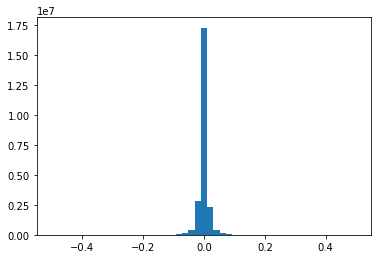

In [28]:
list_ = []
for i in net.parameters():
    i = i.to('cpu').detach().numpy().ravel()
    list_.append(i)
    pass

list_ = np.concatenate(list_)
plt.hist(list_, bins=np.linspace(-0.5, 0.5, 50))
plt.show

In [29]:
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)
# optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False)

In [30]:
def calc_tp1_fp(ll, box):
    tp1 = 0
    fp = 0
    for i in range(len(box)):
        tempo_b = box[i]
        tempo_xmin, tempo_ymin, tempo_xmax, tempo_ymax = tempo_b[1], tempo_b[2], tempo_b[3], tempo_b[4]
        ok = False
        for k in range(len(ll)):
            tempo_l = ll[k]
            tempo_c = [(tempo_l[0]+tempo_l[2])/2, (tempo_l[1]+tempo_l[3])/2]# 正解ラベルの中心
            if tempo_xmin<=tempo_c[0] and tempo_c[0]<=tempo_xmax and tempo_ymin<=tempo_c[1] and tempo_c[1]<=tempo_ymax:
                ok = True
            else:pass
        if ok:
            tp1 += 1
        else:
            fp += 1
    return tp1, fp

In [31]:
def calc_tp2_fn(ll, box):
    tp2_025_under = 0
    tp2_025_upper = 0
    fn_025_under = 0
    fn_025_upper = 0

    for i in range(len(ll)):
        tempo_l = ll[i]
        tempo_c = [(tempo_l[0]+tempo_l[2])/2, (tempo_l[1]+tempo_l[3])/2]# 正解ラベルの中心
        width = tempo_l[2] - tempo_l[0]
        ok_025_under = False
        ok_025_upper = False
#         width_list.append(tempo_l[2] - tempo_l[0])
        
        for k in range(len(box)):  
            tempo_b = box[k]
            tempo_xmin, tempo_ymin, tempo_xmax, tempo_ymax = tempo_b[1], tempo_b[2], tempo_b[3], tempo_b[4]
            
            if width>=0.25:
                if tempo_xmin<=tempo_c[0] and tempo_c[0]<=tempo_xmax and tempo_ymin<=tempo_c[1] and tempo_c[1]<=tempo_ymax:
                    ok_025_upper = True
                else:pass
                
            else:
                if tempo_xmin<=tempo_c[0] and tempo_c[0]<=tempo_xmax and tempo_ymin<=tempo_c[1] and tempo_c[1]<=tempo_ymax:
                    ok_025_under = True
                else:pass
                
        if ok_025_upper:
            tp2_025_upper += 1
        else:
            fn_025_upper += 1
            
        if ok_025_under:
            tp2_025_under += 1
        else:
            fn_025_under += 1
            
    return tp2_025_under, tp2_025_upper, fn_025_under ,fn_025_upper

In [32]:
def precisio_recall(ll, box):
    TP1 = 0
    FP = 0
    TP2_025_under = 0
    TP2_025_upper = 0
    FN_025_upper = 0
    FN_025_under = 0
    
#     width_batch = []
    for i in range(len(ll)):
        box_ = box[i]
        box_ = box_[box_[:, 0]>=0.8]
        ll_ = ll[i]

        tempo_tp1, tempo_fp = calc_tp1_fp(ll_, box_)
        tp2_025_under, tp2_025_upper, fn_025_under ,fn_025_upper = calc_tp2_fn(ll_, box_)

        TP1 += tempo_tp1
        FP += tempo_fp
        TP2_025_under += tp2_025_under
        TP2_025_upper += tp2_025_upper
        FN_025_under += fn_025_under
        FN_025_upper += fn_025_upper
#         width_batch.append(width)
    
    if (TP1+FP) == 0:
        precision = 0
    else:
        precision = TP1/(TP1+FP)
        
    if (TP2_025_under+FN_025_under) == 0:
        recall_025_under = 0
    else:
        recall_025_under = TP2_025_under/(TP2_025_under+FN_025_under)
        
    if (TP2_025_upper+FN_025_upper) == 0:
        recall_025_upper = 0
    else:
        recall_025_upper = TP2_025_upper/(TP2_025_upper+FN_025_upper)
    
    return precision, recall_025_under, recall_025_upper

In [33]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, file_name):
    
#     pos_tempo_list = []
#     neg_tempo_list = []
    train_precision_list = []
    train_recall_025_under_list = []
    train_recall_025_upper_list = []
    val_precision_list = []
    val_recall_025_under_list = []
    val_recall_025_upper_list = []

    # GPUが使えるかを確認
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True
#     early_stopping = EarlyStopping(patience=20, verbose=True, path='weights/%s/earlystopping.pth'%(file_name))
    # イテレーションカウンタをセット
    logs = []

    # epochのループ
    for epoch in range(num_epochs):
        iteration = 0
        val_iter = 0
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和
        
#         train_precision_iter = 0.0
#         train_recall03_under_iter = 0.0
#         train_recall03_upper_iter = 0.0
#         val_precision_iter = 0.0
#         val_recall03_under_iter = 0.0
#         val_recall03_upper_iter = 0.0
        
        
        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                net.eval()

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device, dtype=torch.float)
                targets = [ann.to(device, dtype=torch.float) for ann in targets]  # リストの各要素のテンソルをGPUへ
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)
#                     print(outputs[1][:, :, 1].to('cpu').detach().numpy()[:,:,None].shape)
#                     print(outputs[0].to('cpu').detach().numpy().shape)
                    bbb = np.concatenate([outputs[1][:, :, 1].to('cpu').detach().numpy()[:,:,None], 
                                             outputs[0].to('cpu').detach().numpy()], axis=2)
#                     print(bbb.shape)
                    
#                     print()
                    # 損失の計算
                    loss_l, loss_c = criterion.forward(outputs, targets)
                    loss = loss_l + loss_c
#                     pos_tempo_list.append(pos_mask.to('cpu'))
#                     neg_tempo_list.append(neg_mask.to('cpu'))
#                     print(loss)
#                     訓練時はバックプロパゲーション
                    if phase == 'train':
                        
                        precision, recall_025_under, recall_025_upper = precisio_recall([ann.to('cpu') for ann in targets], bbb)
                        train_precision_list.append(precision)
                        train_recall_025_under_list.append(recall_025_under)
                        train_recall_025_upper_list.append(recall_025_upper)
                        
                        loss.backward()  # 勾配の計算
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める

                        optimizer.step()  # パラメータ更新
                        epoch_train_loss += loss.item()
                        print("\r"+str(iteration)+'/'+str(int(train_data.shape[0]/batch_size))+'       ', end="")
                        iteration += 1

                    # 検証時
                    else:
                        precision, recall_025_under, recall_025_upper = precisio_recall([ann.to('cpu') for ann in targets], bbb)
                        val_precision_list.append(precision)
                        val_recall_025_under_list.append(recall_025_under)
                        val_recall_025_upper_list.append(recall_025_upper)
                        
                        epoch_val_loss += loss.item()
                        val_iter += 1      
                        
        avg_train_loss = epoch_train_loss / iteration
        avg_val_loss = epoch_val_loss / val_iter
        
        
        print('\nepoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f} '.format(epoch+1,
                                                                                  avg_train_loss,
                                                                                  avg_val_loss))
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': avg_train_loss, 'val_loss': avg_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("weights/%s/log_output.csv"%(file_name))
        
#         early_stopping(epoch_val_loss, net)
    
#         if early_stopping.early_stop:
#             print('Early_Stopping')
#             break
            
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/%s/ssd300_'%(file_name) +
                       str(epoch+1) + '.pth')
    return train_precision_list, train_recall_025_under_list, train_recall_025_upper_list, val_precision_list, val_recall_025_under_list, val_recall_025_upper_list

In [ ]:
num_epoch = 300
pd_frame = pd.DataFrame(columns=['iteration', 'phase', 'loss'])
train_precision_list, train_recall_025_under_list, train_recall_025_upper_list, \
val_precision_list, val_recall_025_under_list, val_recall_025_upper_list= train_model(net, 
                                                     dataloaders_dict , criterion, optimizer, num_epochs=num_epoch, file_name='train_300epoch')

使用デバイス： cuda:0
-------------
Epoch 1/300
-------------
（train）
171/171       
epoch 1 || Epoch_TRAIN_Loss:7.0181 ||Epoch_VAL_Loss:4.1456 
timer:  108.9692 sec.
-------------
Epoch 2/300
-------------
（train）
171/171       
epoch 2 || Epoch_TRAIN_Loss:3.5639 ||Epoch_VAL_Loss:3.6220 
timer:  72.9859 sec.
-------------
Epoch 3/300
-------------
（train）
171/171       
epoch 3 || Epoch_TRAIN_Loss:3.1303 ||Epoch_VAL_Loss:3.3437 
timer:  73.3349 sec.
-------------
Epoch 4/300
-------------
（train）
171/171       
epoch 4 || Epoch_TRAIN_Loss:2.8983 ||Epoch_VAL_Loss:3.4999 
timer:  73.5378 sec.
-------------
Epoch 5/300
-------------
（train）
171/171       
epoch 5 || Epoch_TRAIN_Loss:2.6756 ||Epoch_VAL_Loss:3.0145 
timer:  73.5195 sec.
-------------
Epoch 6/300
-------------
（train）
171/171       
epoch 6 || Epoch_TRAIN_Loss:2.4628 ||Epoch_VAL_Loss:2.8971 
timer:  73.7966 sec.
-------------
Epoch 7/300
-------------
（train）
171/171       
epoch 7 || Epoch_TRAIN_Loss:2.3029 ||Epoch_VAL_Loss:2.788

In [ ]:
max(train_precision_list)

In [ ]:
max(val_precision_list)

In [ ]:
max(val_recall_025_under_list), max(train_recall_025_under_list)

In [ ]:
max(val_recall_025_upper_list), max(train_recall_025_upper_list)

In [ ]:
np.save('weights/train_300epoch/train_precision.npy', np.array(train_precision_list))
np.save('weights/train_300epoch/val_precision.npy', np.array(val_precision_list))
np.save('weights/train_300epoch/val_recall_025_under.npy', np.array(val_recall_025_under_list))
np.save('weights/train_300epoch/val_recall_025_upper.npy', np.array(val_recall_025_upper_list))
np.save('weights/train_300epoch/train_recall_025_under.npy', np.array(train_recall_025_under_list))
np.save('weights/train_300epoch/train_recall_025_upper.npy', np.array(train_recall_025_upper_list))

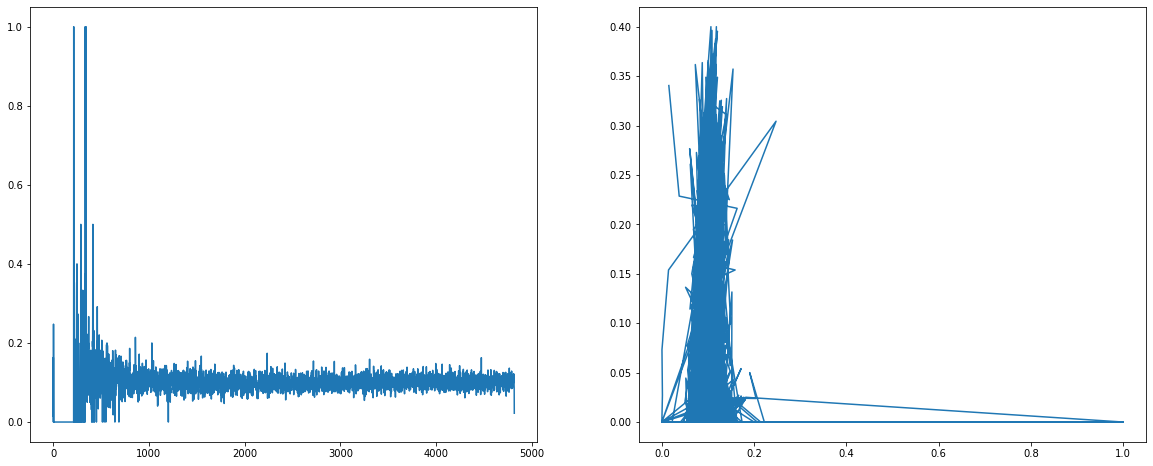

In [40]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(train_precision_list)), train_precision_list)
ax2 = fig.add_subplot(122)
ax2.plot(train_precision_list, train_recall_025_under_list)


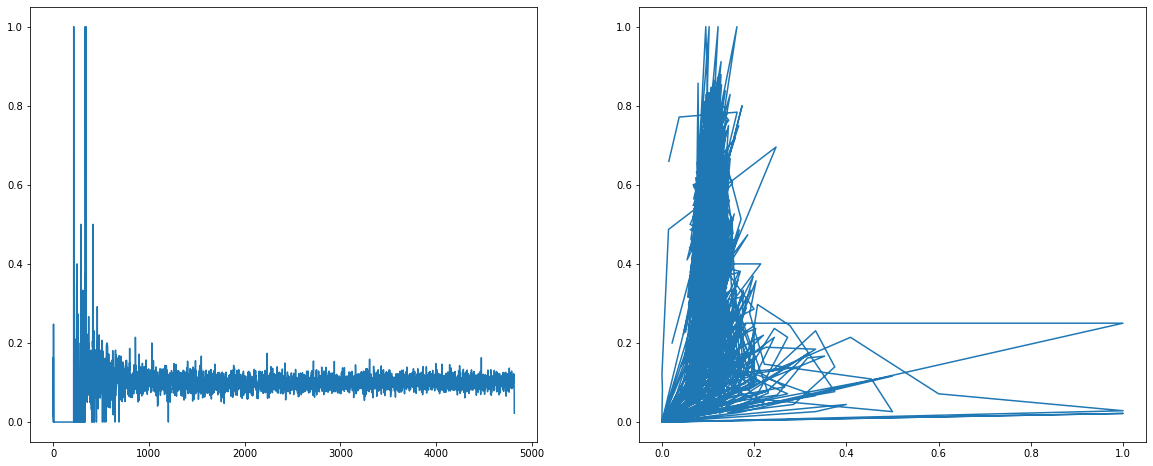

In [41]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(train_precision_list)), train_precision_list)
ax2 = fig.add_subplot(122)
ax2.plot(train_precision_list, train_recall_025_upper_list)


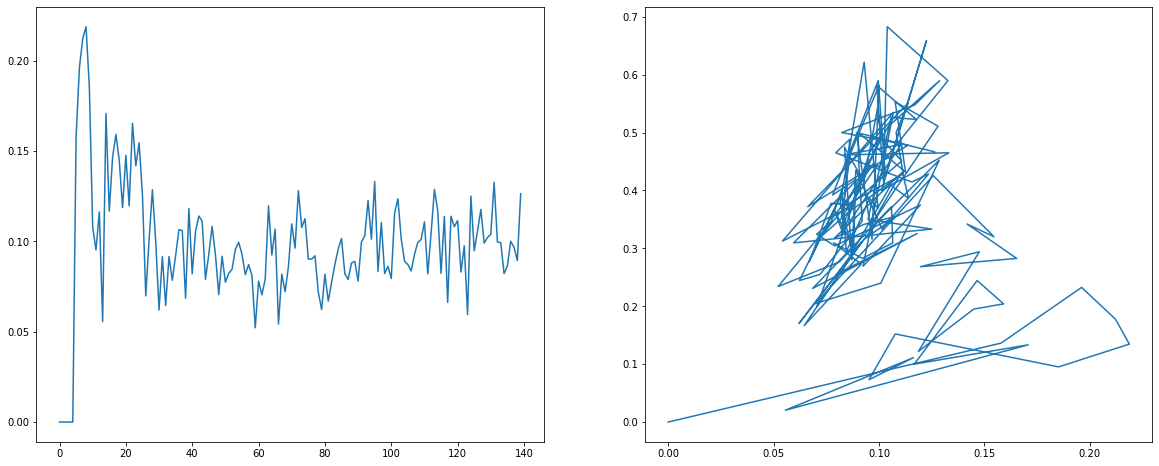

In [42]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(val_precision_list)), val_precision_list)
ax2 = fig.add_subplot(122)
ax2.plot(val_precision_list, val_recall_025_upper_list)


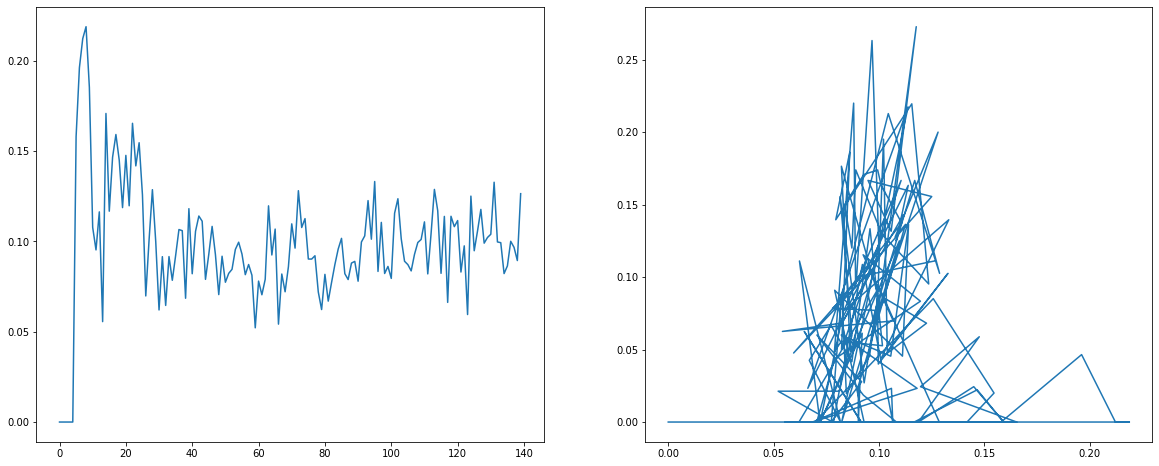

In [43]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(val_precision_list)), val_precision_list)
ax2 = fig.add_subplot(122)
ax2.plot(val_precision_list, val_recall_025_under_list)

In [6]:
loss = pd.read_csv('weights/train_300epoch/log_output.csv')

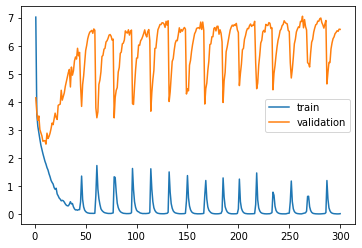

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss['epoch'], loss['train_loss'], label='train')
ax.plot(loss['epoch'], loss['val_loss'], label='validation')

plt.legend()
# fig.savefig('weights/change_loc_conf_8_18/loss.png')